# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Доведём метрику минимум до 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

### План проведения работы

   * Загрузим и подготовим данные. Поясним порядок действий.
   * Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишем выводы.
   * Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдём лучшую. Кратко опишем выводы.
   * Проведём финальное тестирование.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Загрузим датасет и просмотрим основную информацию по нему.

In [2]:
if os.path.exists('Churn.csv'):
    df = pd.read_csv('Churn.csv')
else:
    df = pd.read_csv('/datasets/Churn.csv')

df.info()
display(df.head())
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Первые две колонки являются служебными и добавлены для удобства обработки данных. На вероятность ухода клиента они влияние не оказывают, поэтому для данной работы их можно удалить.

Также можно рассмотреть удаление колонки с фамилиями клиентов.

In [3]:
print(df['Surname'].nunique())
print(df['Surname'].value_counts().head(10))

2932
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
Yeh         25
Shih        25
Genovese    25
Maclean     24
Wright      24
Name: Surname, dtype: int64


Из 10000 записей треть уникальных. Отследить явную зависимость от фамилии клиента при том что в среднем в данных только по 3 записи на каждую - маловероятно. Данный столбец так же стоит удалить.

In [4]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

Приведём названия оставшихся столбцов к стандарту PEP8.

In [5]:
df.rename(columns={
    'CreditScore':'credit_score',
    'Geography':'geography',
    'Gender':'gender',
    'Age':'age',
    'Tenure':'tenure', 'Balance':'balance',
    'NumOfProducts':'num_of_products',
    'HasCrCard':'has_cr_card',
    'IsActiveMember':'is_active_member',
    'EstimatedSalary':'estimated_salary',
    'Exited':'exited'
}, inplace=True)

Проверим содержимое строк с отсутствующими данными в столбце `tenure`.

In [6]:
df[df['tenure'] != df['tenure']]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Почти 10% данных имеют NaN вместо срока обслуживания клиента. Информация для моделирования оттока важная, но, к сожалению, не имея данных хотя бы о дате заключения договора с клиентом восстановить данные невоможно. Ниже попробуем заполнить данные.

Проверим уникальные данные для категориальных столбцов.

In [7]:
print(df['geography'].unique())
print(df['gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Проверим дубликаты.

In [8]:
df.duplicated().sum()

0

Проверим корреляции в данных.

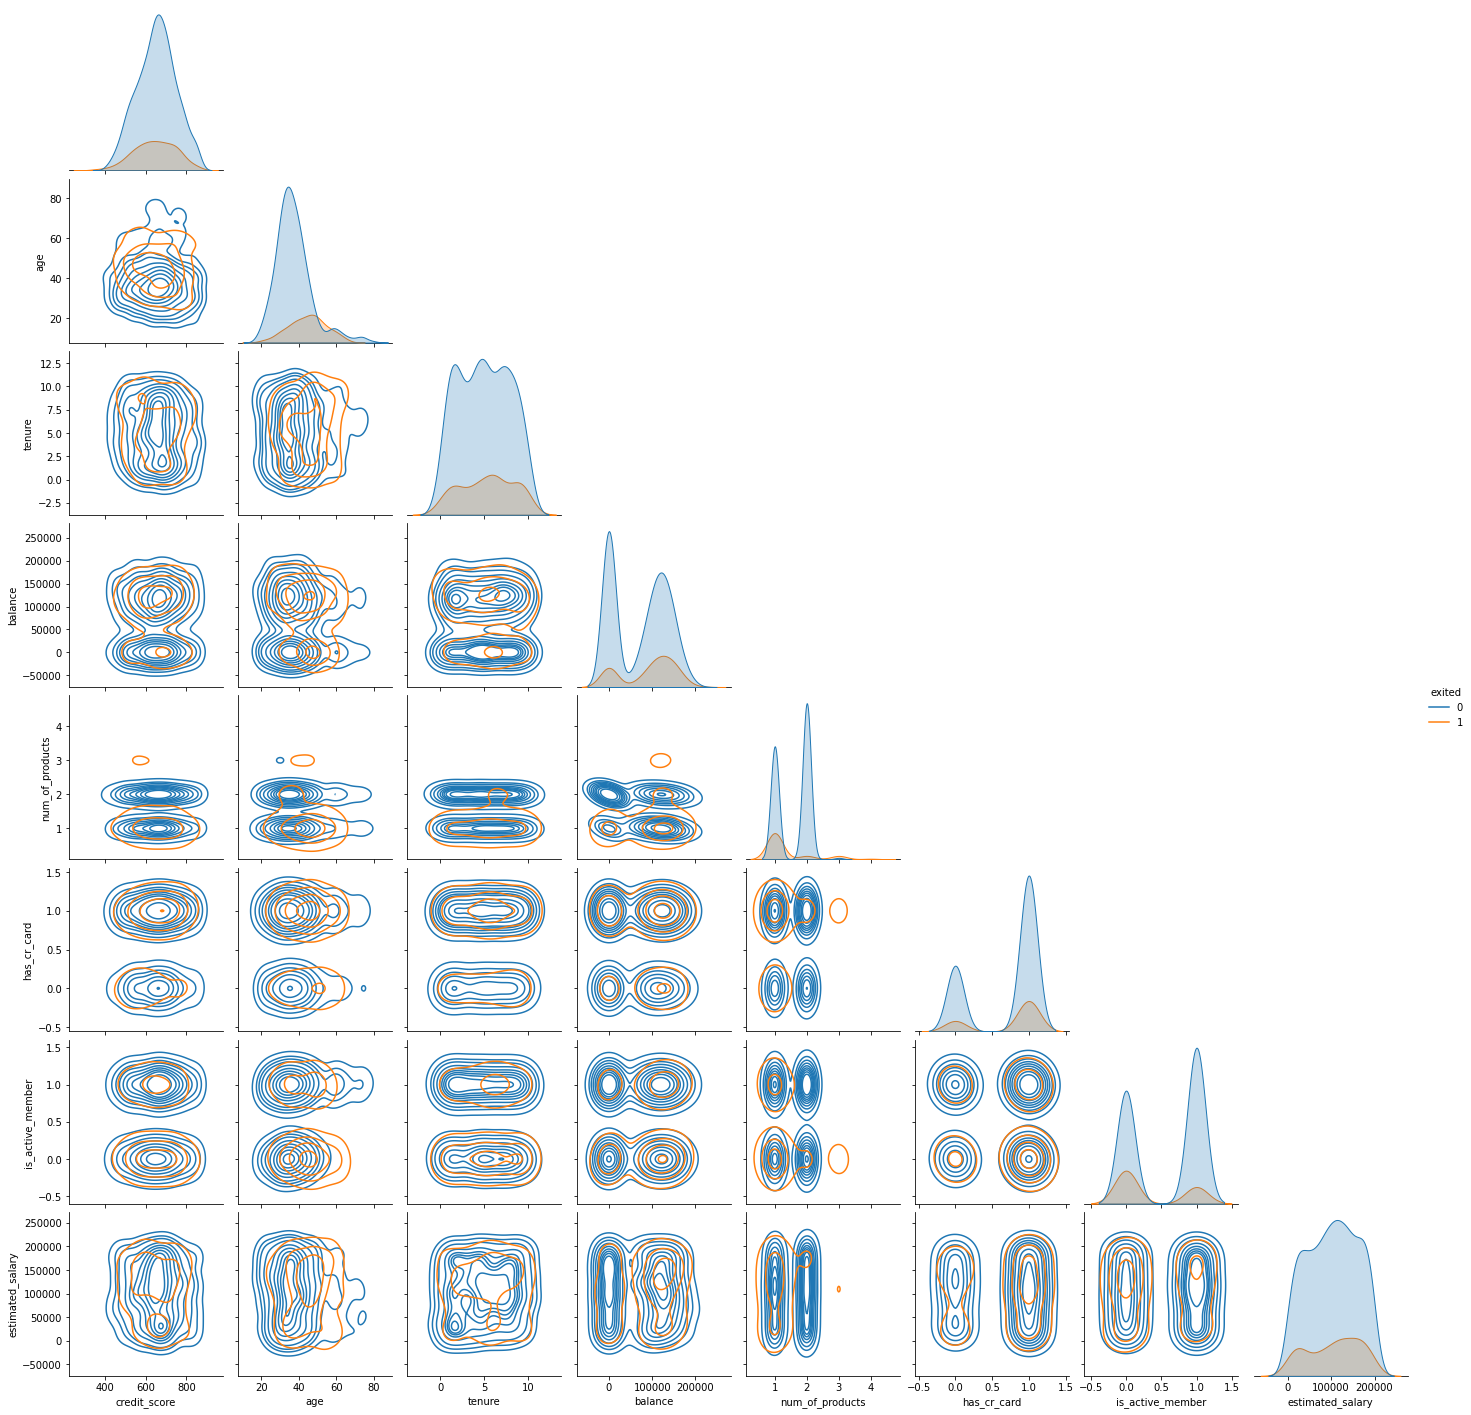

In [9]:
sns.pairplot(df.sample(frac=0.1, random_state=314159), hue='exited', corner=True, kind='kde')
plt.show()

На корреляционной матрице мы увидели некоторые явные зависимости:
   * видна сильная корреляция вероятности ухода клиента от его возраста - средний возраст уходящего клиента равен 45 годам, в то время как текущие клиенты имеют средний возраст 35 лет
   * у б*о*льшей части ушедших клиентов был только один банковский продукт, в  то время как у текущих клиентов в среднем два активных продукта
   * уходящие клиенты являются менее активными
   * срок обслуживания клиента, баланс, наличие кредитки, средитная оценка и ожидаемая зарплата почти не влияют на вероятность ухода

### Перевод категориальных признаков в численные

Используем технику OHE.

In [10]:
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)

### Разбиение на выборки

Зададим макропараметры.

In [11]:
# соотношения выборок
train_ratio = .7
validation_ratio = .15
test_ratio = .15

# случайное зерно
seed = 314159

Проведём разделение данных на цель и признаки.

In [12]:
target = df['exited']
features = df.drop('exited', axis=1)

Проведём разделение на выборки.

In [13]:
features_trainval, features_test, target_trainval, target_test = train_test_split(
    features, target,
    test_size=test_ratio,
    random_state=seed,
    stratify=target
)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_trainval, target_trainval,
    test_size=validation_ratio/(1-test_ratio),
    random_state=seed,
    stratify=target_trainval
)

Проверим разделение.

In [14]:
print(f'Доля тренировочного набора: {features_train.shape[0]/features.shape[0]:.2f}\n\
Доля валидационного набора: {features_valid.shape[0]/features.shape[0]:.2f}\n\
Доля тестового набора: {features_test.shape[0]/features.shape[0]:.2f}')

print(f'Доля ушедших пользователей для тренировочного набора: {target_train.mean():.2f}\n\
Доля ушедших пользователей для валидационного набора: {target_valid.mean():.2f}\n\
Доля ушедших пользователей для тестового набора: {target_test.mean():.2f}')

Доля тренировочного набора: 0.70
Доля валидационного набора: 0.15
Доля тестового набора: 0.15
Доля ушедших пользователей для тренировочного набора: 0.20
Доля ушедших пользователей для валидационного набора: 0.20
Доля ушедших пользователей для тестового набора: 0.20


### Масштабирование числовых признаков

Используем StandardScaler.

In [15]:
pd.options.mode.chained_assignment = None

numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Заполнение пропущенных значений

Используем инструмент SimpleImputer со стратегией mean.

In [16]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(features_train)

features_train_mean = pd.DataFrame(imp_mean.transform(features_train),
                                   index=features_train.index,
                                   columns=features_train.columns)
features_valid_mean = pd.DataFrame(imp_mean.transform(features_valid),
                                   index=features_valid.index,
                                   columns=features_valid.columns)
features_test_mean = pd.DataFrame(imp_mean.transform(features_test),
                                  index=features_test.index,
                                  columns=features_test.columns)

Также сделаем набор данных SimpleImputer со стратегией median.

In [17]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(features_train)

features_train_median = pd.DataFrame(imp_median.transform(features_train),
                                     index=features_train.index,
                                     columns=features_train.columns)
features_valid_median = pd.DataFrame(imp_median.transform(features_valid),
                                     index=features_valid.index,
                                     columns=features_valid.columns)
features_test_median = pd.DataFrame(imp_median.transform(features_test),
                                    index=features_test.index,
                                    columns=features_test.columns)

Обучим модель IterativeImputer на тренировочных признаках и обработаем пропуски.

In [18]:
imp = IterativeImputer(max_iter=10, random_state=seed)
imp.fit(features_train)

features_train = pd.DataFrame(imp.transform(features_train),
                              index=features_train.index,
                              columns=features_train.columns)
features_valid = pd.DataFrame(imp.transform(features_valid),
                              index=features_valid.index,
                              columns=features_valid.columns)
features_test = pd.DataFrame(imp.transform(features_test),
                             index=features_test.index,
                             columns=features_test.columns)

### Вывод

Мы загрузили и предобработали исходные данные. Удалили лишние столбцы, проверили уникальные значения, проверили дубликаты, переименовали столбцы на соответствие PEP8.

Построили корреляционную матрицу для наших данных.
   
Далее мы перевели категориальные данные в численные, разбили данные на выборки и масштабировали числовые признаки.

В последнюю очередь мы заполнили пропуски в столбце `tenure` инструментами SimpleImputer и IterativeImputer.

Можно переходить к исследованию задачи.

## Исследование задачи

### Исследуем баланс классов

Проверим баланс отрицательных и положительных классов.

In [19]:
print(f'Доля положительных классов для тренировочного набора: {target_train.mean():.2%}\n\
Доля положительных классов для валидационного набора: {target_valid.mean():.2%}\n\
Доля положительных классов для тестового набора: {target_test.mean():.2%}')

Доля положительных классов для тренировочного набора: 20.37%
Доля положительных классов для валидационного набора: 20.33%
Доля положительных классов для тестового набора: 20.40%


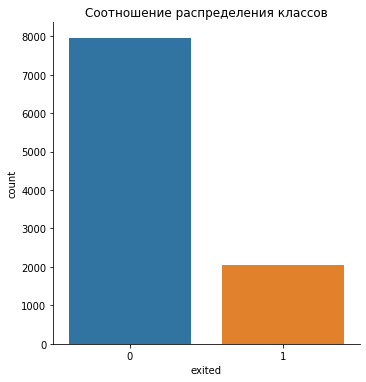

In [20]:
sns.catplot(x='exited', data=df, kind='count', orient='h')
plt.title('Соотношение распределения классов')
plt.show()

Соотношение между объектами классов в исходной выборке примерно 4 отрицательных к 1 положительному.

### Изучение логистической регрессии без учёта дисбаланса классов

Напишем функцию которая будет делать подбор оптимальных параметров модели по разным наборам данных и гиперпараметров.

In [21]:
def logistic_regression(features_train, target_train, features_valid, target_valid, name, class_weight=None):
    '''
    Функция принимает на вход выборки признаков и целей, имя способа которым заполняли пропуски и, опционально,
    даёт возможность отбалансировать классы встроеным методом логистической регрессии.
    Подбор оптимальных параметров модели идёт по решающим алгоритмам.
    '''
    best_f1_lr = 0
    global best_model_lr

    for solver in tqdm(['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], desc='Progress: '):
        model = LogisticRegression(random_state=seed,
                                   solver=solver,
                                   max_iter=100,
                                   class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        if f1 > best_f1_lr:
            best_model_lr = model
            best_auc_roc_lr = auc_roc
            best_solver_lr = solver
            best_f1_lr = f1

    print(f'Модель Logistic regression, лучшая F1-мера={best_f1_lr:.7f}, лучшая AUC_ROC={best_auc_roc_lr:.7f},')
    print(f'solver={best_solver_lr},')
    print(f'{name}, признаки отбалансированы с помощью class_weight={class_weight == "balanced"}')

In [22]:
logistic_regression(features_train, target_train, features_valid, target_valid, 'Iterative Imputer')
logistic_regression(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean')
logistic_regression(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median')

Progress: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


Модель Logistic regression, лучшая F1-мера=0.3260341, лучшая AUC_ROC=0.7625434,
solver=liblinear,
Iterative Imputer, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


Модель Logistic regression, лучшая F1-мера=0.3260341, лучшая AUC_ROC=0.7625516,
solver=liblinear,
Simple Imputer mean, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

Модель Logistic regression, лучшая F1-мера=0.3260341, лучшая AUC_ROC=0.7625516,
solver=liblinear,
Simple Imputer median, признаки отбалансированы с помощью class_weight=False


### Изучение решающего дерева без учёта дисбаланса классов

In [23]:
def decision_tree(features_train, target_train, features_valid, target_valid, name, class_weight=None):
    '''
    Функция принимает на вход выборки признаков и целей, имя способа которым заполняли пропуски и, опционально,
    даёт возможность отбалансировать классы встроеным методом решающего дерева.
    Подбор оптимальных параметров модели идёт по макисмальной глубине, максимальному количеству листов на ноде,
    минимальному количеству образцов.
    '''
    best_f1_dt = 0
    global best_model_dt

    for depth in tqdm(range(1, 16), desc='Progress: '):
        for leaf in range(2,31):
            model = DecisionTreeClassifier(max_depth=depth,
                                           max_leaf_nodes=leaf,
                                           random_state=seed,
                                           class_weight=class_weight)
            model.fit(features_train, target_train)
            prediction_valid = model.predict(features_valid)
            f1 = f1_score(target_valid, prediction_valid)
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

            if f1 > best_f1_dt:
                best_model_dt = model
                best_auc_roc_dt = auc_roc
                best_f1_dt = f1
                best_depth_dt = depth
                best_leaf_dt = leaf
    
    print(f'Модель Decision Tree, лучшая F1-мера={best_f1_dt:.7f}, лучшая AUC_ROC={best_auc_roc_dt:.7f},')
    print(f'max_depth={best_depth_dt}, max_leaf_nodes={best_leaf_dt}')
    print(f'{name}, признаки отбалансированы с помощью class_weight={class_weight == "balanced"}')

In [24]:
decision_tree(features_train, target_train, features_valid, target_valid, 'Iterative Imputer')
decision_tree(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean')
decision_tree(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median')

Progress: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Модель Decision Tree, лучшая F1-мера=0.5553398, лучшая AUC_ROC=0.7973894,
max_depth=5, max_leaf_nodes=11
Iterative Imputer, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Модель Decision Tree, лучшая F1-мера=0.5553398, лучшая AUC_ROC=0.7973894,
max_depth=5, max_leaf_nodes=11
Simple Imputer mean, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

Модель Decision Tree, лучшая F1-мера=0.5553398, лучшая AUC_ROC=0.7973894,
max_depth=5, max_leaf_nodes=11
Simple Imputer median, признаки отбалансированы с помощью class_weight=False


### Изучение случайного леса без учёта дисбаланса классов

In [25]:
def random_forest(features_train, target_train, features_valid, target_valid, name, class_weight=None):
    '''
    Функция принимает на вход выборки признаков и целей, имя способа которым заполняли пропуски и, опционально,
    даёт возможность отбалансировать классы встроеным методом случайного леса.
    Подбор оптимальных параметров модели идёт по глубине и количеству деревьев.
    '''
    best_f1_rf = 0
    global best_model_rf

    for est in tqdm(range(1, 1001, 100), desc='Progress: '):
        for depth in range(1, 15):
            model = RandomForestClassifier(n_estimators=est,
                                           max_depth=depth,
                                           random_state=seed,
                                           n_jobs=-1,
                                           class_weight=class_weight)
            model.fit(features_train, target_train)
            prediction_valid = model.predict(features_valid)
            f1 = f1_score(target_valid, prediction_valid)
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

            if f1 > best_f1_rf:
                best_model_rf = model
                best_auc_roc_rf = auc_roc
                best_f1_rf = f1
                best_est_rf = est
                best_depth_rf = depth
                   
    print(f'Модель Random Forest, лучшая F1-мера={best_f1_rf:.7f}, лучшая AUC_ROC={best_auc_roc_rf:.7f},')
    print(f'depth={best_depth_rf}, n_estimators={best_est_rf}')
    print(f'{name}, признаки отбалансированы с помощью class_weight={class_weight == "balanced"}')

In [26]:
random_forest(features_train, target_train, features_valid, target_valid, 'Iterative Imputer')
random_forest(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean')
random_forest(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median')

Progress: 100%|██████████| 10/10 [05:05<00:00, 30.51s/it]


Модель Random Forest, лучшая F1-мера=0.5660377, лучшая AUC_ROC=0.8507223,
depth=12, n_estimators=201
Iterative Imputer, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 10/10 [04:59<00:00, 29.95s/it]


Модель Random Forest, лучшая F1-мера=0.5619835, лучшая AUC_ROC=0.8517594,
depth=13, n_estimators=501
Simple Imputer mean, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 10/10 [05:03<00:00, 30.40s/it]

Модель Random Forest, лучшая F1-мера=0.5578512, лучшая AUC_ROC=0.8540010,
depth=12, n_estimators=301
Simple Imputer median, признаки отбалансированы с помощью class_weight=False


### Вывод

Без учёта баланса классов мы построили и обучили три модели, подобрали оптимальные параметры.

Лучшую F1-меру показала модель случайного леса.

При несбалансированных классах метрика F1 на логистической регресси оказалась наименьшей, при большом AUC_ROC.

Попробуем повторить обучение, учитывая баланс классов.

## Борьба с дисбалансом

Отрицательных классов в 4 раза больше чем положительных. Необходимо отбалансировать данные, для этого мы можем воспользоваться следующими методами:

   * арумент `class_weight` в гиперпараметрах моделей
   * upsampling низкочастотного класса
   * downsampling высокочастотного класса

### Аргумент `class_weight` в параметрах моделей

In [27]:
logistic_regression(features_train, target_train, features_valid, target_valid, 'Iterative Imputer', class_weight='balanced')
logistic_regression(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean', class_weight='balanced')
logistic_regression(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median', class_weight='balanced')

Progress: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Модель Logistic regression, лучшая F1-мера=0.4800937, лучшая AUC_ROC=0.7651663,
solver=liblinear,
Iterative Imputer, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Модель Logistic regression, лучшая F1-мера=0.4800937, лучшая AUC_ROC=0.7651663,
solver=liblinear,
Simple Imputer mean, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

Модель Logistic regression, лучшая F1-мера=0.4800937, лучшая AUC_ROC=0.7651691,
solver=liblinear,
Simple Imputer median, признаки отбалансированы с помощью class_weight=True


In [28]:
decision_tree(features_train, target_train, features_valid, target_valid, 'Iterative Imputer', class_weight='balanced')
decision_tree(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean', class_weight='balanced')
decision_tree(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median', class_weight='balanced')

Progress: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Модель Decision Tree, лучшая F1-мера=0.5811321, лучшая AUC_ROC=0.8421908,
max_depth=7, max_leaf_nodes=26
Iterative Imputer, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Модель Decision Tree, лучшая F1-мера=0.5811321, лучшая AUC_ROC=0.8421908,
max_depth=7, max_leaf_nodes=26
Simple Imputer mean, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]

Модель Decision Tree, лучшая F1-мера=0.5811321, лучшая AUC_ROC=0.8421908,
max_depth=7, max_leaf_nodes=26
Simple Imputer median, признаки отбалансированы с помощью class_weight=True


In [29]:
random_forest(features_train, target_train, features_valid, target_valid, 'Iterative Imputer', class_weight='balanced')
random_forest(features_train_mean, target_train, features_valid_mean, target_valid, 'Simple Imputer mean', class_weight='balanced')
random_forest(features_train_median, target_train, features_valid_median, target_valid, 'Simple Imputer median', class_weight='balanced')

Progress: 100%|██████████| 10/10 [05:05<00:00, 30.57s/it]


Модель Random Forest, лучшая F1-мера=0.5891980, лучшая AUC_ROC=0.8481048,
depth=11, n_estimators=101
Iterative Imputer, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 10/10 [04:59<00:00, 29.97s/it]


Модель Random Forest, лучшая F1-мера=0.5965463, лучшая AUC_ROC=0.8482338,
depth=10, n_estimators=401
Simple Imputer mean, признаки отбалансированы с помощью class_weight=True


Progress: 100%|██████████| 10/10 [04:54<00:00, 29.43s/it]

Модель Random Forest, лучшая F1-мера=0.5930599, лучшая AUC_ROC=0.8483298,
depth=10, n_estimators=701
Simple Imputer median, признаки отбалансированы с помощью class_weight=True


Во всех трёх моделях видно улучшение F1-метрики, а также AUC_ROC. Балансирование классов улучшило модели.

При этом, как и в случае несбалансированных классов, влияние способа заполнения на метрики минимальное. В дальнейших тестах будем использовать метод заполнения Simple Imputer median.

### Метод балансирования - upsampling

In [30]:
def upsample(features, target, rate):
    '''
    Функция принимает набор признаков и целей, и производит апскейл положительных классов в заданное количество раз.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_up = pd.concat([features_zeros] + [features_ones] * rate)
    target_up = pd.concat([target_zeros] + [target_ones] * rate)
    
    features_up, target_up = shuffle(
        features_up, target_up, random_state=seed)
    
    return features_up, target_up

Проведём масштабирование.

In [31]:
rate = int(np.ceil((1 - target_train.mean()) / target_train.mean()))

features_train_up, target_train_up = upsample(features_train_median, target_train, rate)
features_valid_up, target_valid_up = upsample(features_valid_median, target_valid, rate)
features_test_up, target_test_up = upsample(features_test_median, target_test, rate)

Протестируем наши модели на выборке.

In [32]:
logistic_regression(features_train_up, target_train_up, features_valid_up, target_valid_up, 'Upscaling')
decision_tree(features_train_up, target_train_up, features_valid_up, target_valid_up, 'Upscaling')
random_forest(features_train_up, target_train_up, features_valid_up, target_valid_up, 'Upscaling')

Progress: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Модель Logistic regression, лучшая F1-мера=0.6875261, лучшая AUC_ROC=0.7651279,
solver=liblinear,
Upscaling, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Модель Decision Tree, лучшая F1-мера=0.7808702, лучшая AUC_ROC=0.8375293,
max_depth=6, max_leaf_nodes=17
Upscaling, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 10/10 [07:04<00:00, 42.49s/it]

Модель Random Forest, лучшая F1-мера=0.7468031, лучшая AUC_ROC=0.8435942,
depth=6, n_estimators=701
Upscaling, признаки отбалансированы с помощью class_weight=False


Во всех случаях F1-метрика выросла, а AUC_ROC осталась на прежнем уровне.

### Метод балансирования - downsampling

In [33]:
def downsample(features, target, rate):
    '''
    Функция принимает набор признаков и целей, и производит даунскейл отрицательных классов в заданное количество раз.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down = pd.concat(
        [features_zeros.sample(frac=(1 / rate), random_state=12345)] + [features_ones])
    target_down = pd.concat(
        [target_zeros.sample(frac=(1 / rate), random_state=12345)] + [target_ones])
    
    features_down, target_down = shuffle(
        features_down, target_down, random_state=seed)
    
    return features_down, target_down

Проведём масштабирование.

In [34]:
features_train_down, target_train_down = downsample(features_train_median, target_train, rate)
features_valid_down, target_valid_down = downsample(features_valid_median, target_valid, rate)
features_test_down, target_test_down = downsample(features_test_median, target_test, rate)

Протестируем наши модели на выборке.

In [35]:
logistic_regression(features_train_down, target_train_down, features_valid_down, target_valid_down, 'Downscaling')
decision_tree(features_train_down, target_train_down, features_valid_down, target_valid_down, 'Downscaling')
random_forest(features_train_down, target_train_down, features_valid_down, target_valid_down, 'Downscaling')

Progress: 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Модель Logistic regression, лучшая F1-мера=0.6864686, лучшая AUC_ROC=0.7540984,
solver=liblinear,
Downscaling, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Модель Decision Tree, лучшая F1-мера=0.7672552, лучшая AUC_ROC=0.8176709,
max_depth=6, max_leaf_nodes=14
Downscaling, признаки отбалансированы с помощью class_weight=False


Progress: 100%|██████████| 10/10 [02:45<00:00, 16.57s/it]

Модель Random Forest, лучшая F1-мера=0.7671692, лучшая AUC_ROC=0.8434234,
depth=11, n_estimators=701
Downscaling, признаки отбалансированы с помощью class_weight=False


### Вывод

Мы обучили модели на наборах данных со сбалансированными классами. Балансировку проводили тремя разными способами: `class_weight` параметр, Upscaling редкочастотных классов, Downscaling высокочастотных классов.

Лучшая метрика F1 = 0,767 и AUC_ROC = 0,843 получились на модели RandomForestClassifier, при заполнении пропущенных значений методом SimpleImputer с параметром `median`, балансировке классов методом Downscale, глубине = 11 и количестве оценщиков = 701.

Проверим качество лучшей модели на тестовом наборе данных.

## Тестирование модели

Перед проверкой модели на тестовом наборе данных, объединим для обучения валидационный и тренировочные наборы данных.

In [36]:
features_trainval_down = pd.concat([features_train_down] + [features_valid_down])
target_trainval_down = pd.concat([target_train_down] + [target_valid_down])

Обучим модель случайного леса, с ранее подобранными параметрами.

In [37]:
best_model_rf.fit(features_trainval_down, target_trainval_down)
prediction_test = best_model_rf.predict(features_test_down)
f1 = f1_score(target_test_down, prediction_test)
probabilities_test = best_model_rf.predict_proba(features_test_down)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test_down, probabilities_one_test)

print(f'На тестовой выборке метрика F1={f1:.3f}, AUC_ROC={auc_roc:.3f}')

На тестовой выборке метрика F1=0.749, AUC_ROC=0.853


Построим ROC.

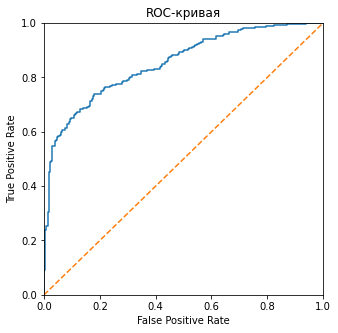

In [38]:
fpr, tpr, thresholds = roc_curve(target_test_down, probabilities_one_test)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")

plt.show()

Проверим модель на адекватность. Сравним со случайной моделью.

In [39]:
model_dc = DummyClassifier(strategy='uniform', random_state=seed)
model_dc.fit(features_trainval_down, target_trainval_down)
prediction_dc = model_dc.predict(features_test_down)
f1 = f1_score(target_test_down, prediction_dc)
probabilities_dc = model_dc.predict_proba(features_test_down)
probabilities_one_dc = probabilities_dc[:, 1]
auc_roc = roc_auc_score(target_test_down, probabilities_one_dc)

print(f'На случайной модели метрика F1={f1:.3f}, AUC_ROC={auc_roc:.3f}')

На случайной модели метрика F1=0.526, AUC_ROC=0.500


Сравним результат с лучшей константной моделью.

In [40]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=seed)
model_dc_mf.fit(features_trainval_down, target_trainval_down)
prediction_dc_mf = model_dc_mf.predict(features_test_down)
f1 = f1_score(target_test_down, prediction_dc_mf)
probabilities_dc_mf = model_dc_mf.predict_proba(features_test_down)
probabilities_one_dc_mf = probabilities_dc_mf[:, 1]
auc_roc = roc_auc_score(target_test_down, probabilities_one_dc_mf)

print(f'Для константной модели метрика F1={f1:.3f}, AUC_ROC={auc_roc:.3f}')

Для константной модели метрика F1=0.673, AUC_ROC=0.500


### Вывод

Мы провели тестирование лучшей модели на тестовой выборке, предварительно обучив модель на суммарной выборке из обучающей и валидационной.

Получили F1-метрику = 0.749 и AUC_ROC=0.853

Построили график ROC.

Сравнением со случайной моделью и константной моделью наиболее частотного класса доказали адекватность выбраной модели.

## Общий вывод

В ходе данной работы мы провели исследование данных об оттоке клиентов банка.

Мы подготовили исходные данные, заполнили пропуски, перевели категориальные признаки в численные, масштабировали признаки.

Мы провели исследование моделей машинного обучения Логистическая регрессия, Дерево решений, Случайный лес на выборках с разным способом заполнения без учёта дисбаланса классов.

Исследовали различные методы борьбы с дисбалансом: встроенный параметр `class_weight`, upscaling, downscaling. Выбрали лучший и проверили все три модели на валидационной выборке.

Выбрав лучшую модель по метрике F1, мы провели проверку модели на тестовой выборке.

Модель RandomForestClassifier с параметрами depth=11, n_estimators=701, на выборке с заполнением методом SimpleImputer `median` и с методом балансирования классов downscaling показала на тестовой выборке F1-метрику = 0.749 и AUC_ROC=0.853

Мы построили ROC кривую для данной модели, а также убедились в её адекватности.